# Wine Consumption and Winery Production Effects on Car Crash Fatality Rate

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
import scipy.stats as stats

### reading in all the data

In [3]:
total_wine_producers_df = pd.read_csv(os.path.join("..","Data","Clean",
                                                   "bonded_wine_producers_by_state_1999_june_2019_clean.csv"))
state_abbrevs = pd.read_csv(os.path.join("..","Data","Raw","state_abbrevs.csv"))
populations_df = pd.read_csv(os.path.join("..","Data","Clean",
                                          "Annual_Resident_Population_Estimates_UTF8.csv"))
consumption_df = pd.read_csv(os.path.join("..","Data","Clean",
                                       "per_capita_alcohol_consumption_geographic_1977_2017_clean.csv"))

### initial cleanup

In [6]:
# years to analyze
crash_years = [str(x) for x in range(2010, 2019,1)]

# NAs will be filled with 0
total_wine_producers_df.fillna(0, inplace=True)
state_abbrevs.rename(columns={"State Name": "STATENAME"}, inplace=True)
# adding in the full state names to the wine producers data
total_wine_producers_df = total_wine_producers_df.merge(state_abbrevs, on="STATE", how="outer")

consumption_df = consumption_df.loc[:,["geographic area", "Year","Wine"]]
consumption_df = consumption_df.loc[consumption_df["Year"].isin(crash_years),:]
consumption_df["Year"] = consumption_df["Year"].astype(str)
consumption_df.rename(columns = {"Year":"CaseYear", "geographic area": "STATENAME"}, inplace=True)


In [7]:
# this data was stored as a float, this removes the ".0" after it was cast to strings
consumption_df["CaseYear"] = [x[0:4] for x in consumption_df["CaseYear"]]

In [8]:
# will use these throughout analysis for the list of the states to focus on
state_colors = \
{
    "California": "blue",
    "Colorado": "red",
    "Oregon": "purple",
    "Texas": "xkcd:burnt orange",
    "Washington": "green"
}


### Cleaning up state population df -- only looking at 5 states and their estimated populations from 2010-2018

In [18]:
# state_populations_df = populations_df.loc[populations_df["CTYNAME"].isin(state_colors.keys()), :]
state_populations_df = populations_df.loc[populations_df["CTYNAME"]==populations_df["STNAME"],:]
state_populations_df = state_populations_df.iloc[:, 5:18]
state_populations_df.drop(["CTYNAME","CENSUS2010POP","ESTIMATESBASE2010"], axis=1, inplace=True)
state_populations_df.rename(columns = {"STNAME":"STATENAME", "POPESTIMATE2010":"2010", 
                                       "POPESTIMATE2011":"2011", "POPESTIMATE2012":"2012", 
                                       "POPESTIMATE2013":"2013", "POPESTIMATE2014":"2014", 
                                       "POPESTIMATE2015":"2015", "POPESTIMATE2016":"2016", 
                                       "POPESTIMATE2017":"2017", "POPESTIMATE2018":"2018"}, inplace=True)
state_populations_df = state_populations_df.transpose()
state_populations_df.columns = state_populations_df.iloc[0,:]
state_populations_df.drop(state_populations_df.index[0], inplace=True)
state_populations_df

STATENAME,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2010,4785448,713906,6407774,2921978,37320903,5048281,3579125,899595,605085,605085,...,816165,6355301,25242679,2775334,625880,8023680,6742902,1854214,5690479,564483
2011,4798834,722038,6473497,2940407,37641823,5121771,3588023,907316,619602,619602,...,823484,6397410,25646227,2814216,626979,8100469,6821655,1856074,5704755,567224
2012,4815564,730399,6556629,2952109,37960782,5193721,3594395,915188,634725,634725,...,833496,6451281,26089620,2853467,626063,8185229,6892876,1856764,5719855,576270
2013,4830460,737045,6634999,2959549,38280824,5270482,3594915,923638,650431,650431,...,842270,6493432,26489464,2897927,626212,8253053,6962906,1853873,5736952,582123
2014,4842481,736307,6733840,2967726,38625139,5351218,3594783,932596,662513,662513,...,849088,6540826,26977142,2937399,625218,8312076,7052439,1849467,5751974,582548
2015,4853160,737547,6833596,2978407,38953142,5452107,3587509,941413,675254,675254,...,853933,6590808,27486814,2982497,625197,8362907,7163543,1841996,5761406,585668
2016,4864745,741504,6945452,2990410,39209127,5540921,3578674,949216,686575,686575,...,862890,6645011,27937492,3042613,623644,8410946,7294680,1830929,5772958,584290
2017,4875120,739786,7048876,3002997,39399349,5615902,3573880,957078,695691,695691,...,873286,6708794,28322717,3103118,624525,8465207,7425432,1817048,5792051,578934
2018,4887871,737438,7171646,3013825,39557045,5695564,3572665,967171,702455,702455,...,882235,6770010,28701845,3161105,626299,8517685,7535591,1805832,5813568,577737


### Initialize dataframe to store crash fatality information from one query of the API

In [25]:
# a single request to get the names of the columns
crashes_loc_base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCrashesByLocation?"

crash_params = \
    {
        "fromCaseYear" : "2011",
        "toCaseYear" : "2011",
        "state" : "6",
        "county" : "",
        "format": "json"
    }
response = requests.get(crashes_loc_base_url, params=crash_params).json()
crash_df = pd.DataFrame(response["Results"][0])
# removing all rows:
crash_df = crash_df.drop(crash_df.index[:])
crash_df.head()


,CITY,CITYNAME,COUNTY,COUNTYNAME,CaseYear,FATALS,LATITUDE,LONGITUD,STATE,STATENAME,ST_CASE,TOTALVEHICLES,TWAY_ID,TWAY_ID2,VE_FORMS


### Query the National Highway Traffic Safety Administration (NHTSA) Fatality Analysis Reporting System (FARS) API

In [28]:
crashes_loc_base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCrashesByLocation?"
# yes, I pulled data for all the states, plus some summaries and DC and PR
state_ids = range(1,57,1)
# the API limits the number of crashes returned to 5,000 per call. This list will store the number of
# responses per call. If that number is 5000, we'll need to split up that call to get all the crashes.
nCrashes = [None]*len(crash_years)*len(state_ids)
c = 0
for year in crash_years:
    for state in state_ids:
        crash_params = \
        {
            "fromCaseYear" : str(year),
            "toCaseYear" : str(year),
            "state" : str(state),
            "county" : "",
            "format": "json"
        }
        
        response = requests.get(crashes_loc_base_url, params=crash_params)
        response_json = response.json()
        if response.status_code == 200:
            try:
                # building the list of all fatal crashes
                crash_df = crash_df.append(response_json["Results"][0])
                nCrashes[c] = len(response_json["Results"][0])
            except IndexError: 
                continue
        c += 1

### Verify request dataCheck for requests that hit max query limit

In [35]:
### Check for requests that hit max query limit
[x for x in [i for i in nCrashes if i] if x>4999]

[]

In [33]:
# no NAs
crash_df.isna().any()

CITY             False
CITYNAME         False
COUNTY           False
COUNTYNAME       False
CaseYear         False
FATALS           False
LATITUDE         False
LONGITUD         False
STATE            False
STATENAME        False
ST_CASE          False
TOTALVEHICLES    False
TWAY_ID          False
TWAY_ID2         False
VE_FORMS         False
dtype: bool

### Write to .csv

In [32]:
crash_df.to_csv(os.path.join("..", "Data", "Raw", "All_US_Fatal_Crashes_2010-2018.csv"))

### Cleaning up crash data, optionally read in crash data

In [36]:
# optionally read in the saved csv so we dont have to request from the API upon reopening notebook
# crash_df=pd.read_csv(os.path.join("..","Data","Raw","All_US_Fatal_Crashes_2010-2018.csv"))
# crash_df.drop("Unnamed: 0", axis=1, inplace=True)
crash_df["FATALS"] = crash_df["FATALS"].astype(int)

crash_df.head()

,CITY,CITYNAME,COUNTY,COUNTYNAME,CaseYear,FATALS,LATITUDE,LONGITUD,STATE,STATENAME,ST_CASE,TOTALVEHICLES,TWAY_ID,TWAY_ID2,VE_FORMS
0,2340,OPELIKA,81,LEE (81),2010,1,32.64106389,-85.354691670,1,Alabama,10001,1,I-85,,1
1,1080,EVERGREEN,35,CONECUH (35),2010,1,31.43044722,-86.956694440,1,Alabama,10002,1,5010,,1
2,2100,MOBILE,97,MOBILE (97),2010,1,30.69163056,-88.085777780,1,Alabama,10003,3,US-SR 42,4639,3
3,160,ASHVILLE,115,ST CLAIR (115),2010,1,33.86870000,-86.291163890,1,Alabama,10004,2,US-SR 53,,2
4,0,NOT APPLICABLE,117,SHELBY (117),2010,1,33.30974167,-86.787222220,1,Alabama,10005,2,I-65,,2


### reformatting crash data for easier plotting and to merge with wine production data and state population data

In [37]:
state_year_group = crash_df.groupby(["STATENAME", "CaseYear"])
crash_counts = state_year_group.sum()["FATALS"].reset_index()
crash_counts_pivot_state = crash_counts.pivot(index="STATENAME",
                                              columns="CaseYear",values="FATALS").reset_index()
crash_counts_pivot_state.columns = crash_counts_pivot_state.columns.astype(str)

consumption_pivot_state = consumption_df.pivot(index="STATENAME", columns="CaseYear", 
                                               values="Wine").reset_index()

### Merging wine producers, crashes, and populations into one dataframe

In [63]:
wine_crash = pd.merge(total_wine_producers_df, crash_counts_pivot_state, on="STATENAME", how="outer", 
                      suffixes=("_wine","_crash"))
wine_crash = wine_crash.merge(state_populations_df.transpose().reset_index(), on="STATENAME",how="outer")
wine_crash = wine_crash.merge(consumption_pivot_state, on="STATENAME",how="outer",
                              suffixes=["_pops","_cons"])
wine_crash.rename(columns={"2018":"2018_pops"}, inplace=True)
# dropping duplicate DC and summaries
wine_crash.drop(wine_crash.index[[7, 52,53,54,55,56,57]], inplace=True)
# boolean index for the top 5 states
top_states = wine_crash["STATENAME"].isin(state_colors.keys())

### Plots and Regressions

C:\Users\epayn\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


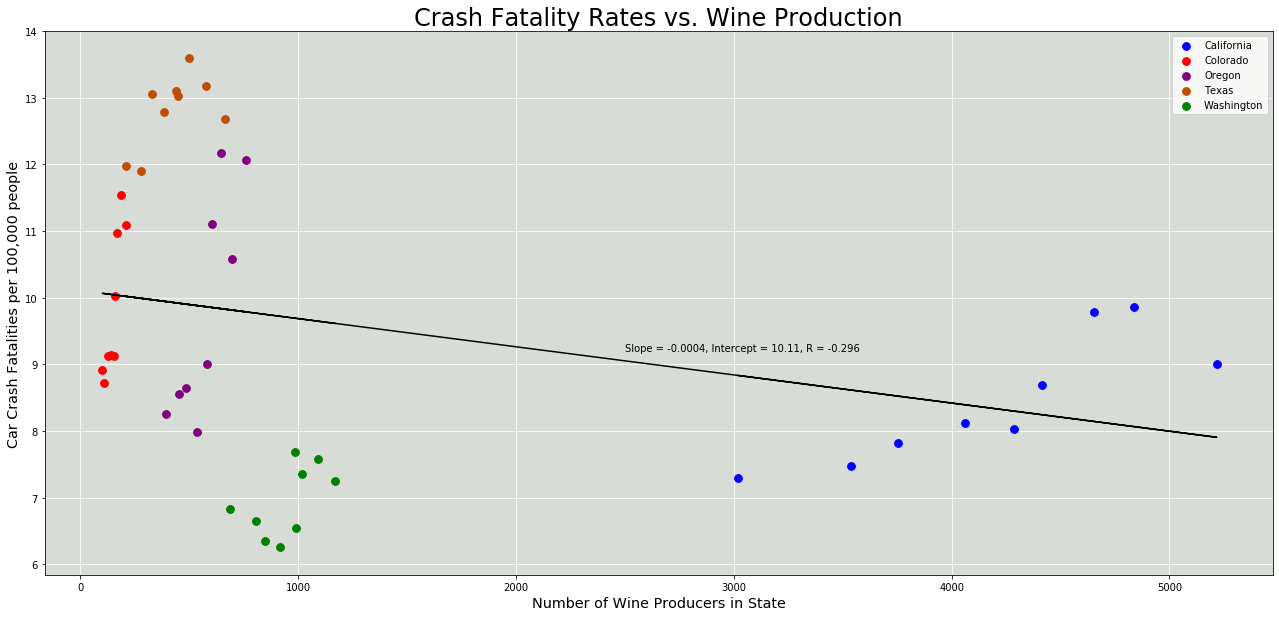

In [74]:
wp = wine_crash.loc[top_states, [x + "_wine" for x in crash_years]].values.flatten()
cr = wine_crash.loc[top_states, [x + "_crash" for x in crash_years]].values.flatten()*100000/\
                                          wine_crash.loc[top_states, [x + "_pops" for x in crash_years]].values.flatten()

# # There is actually a negative correlation between wine production and crash fatalities
prod_crash_regression = stats.linregress(wp,cr.astype(float))

plt.figure(figsize=(22,10), facecolor="None")
plt.title("Crash Fatality Rates vs. Wine Production", fontsize=24)
axes = plt.axes()

axes.set_facecolor("xkcd:light grey")
axes.set_axisbelow(True)
axes.grid(axis="both", color = "w")

axes.set_xlabel("Number of Wine Producers in State",size="x-large")
axes.set_ylabel("Car Crash Fatalities per 100,000 people",size="x-large")

for state in state_colors.keys():
    
    staterow = wine_crash["STATENAME"]==state
    
    # transposing these so that the scatter plot will accept them as arguments
    wineprods = wine_crash.loc[staterow, [x + "_wine" for x in crash_years]].transpose()
    crashes = wine_crash.loc[staterow, [x + "_crash" for x in crash_years]].transpose()
    pops = wine_crash.loc[staterow, [x + "_pops" for x in crash_years]].transpose()
    # rate per 100,000
    crashrates = crashes.values*100000/pops.values
    
    plt.scatter(wineprods.values, crashrates, c=state_colors[state], label=state, s=60)

    plt.legend(loc="upper right")

# here w is the list of all wine producers in the top 5 states, used previously for the regression
plt.plot(wp, wp*prod_crash_regression[0] + prod_crash_regression[1], c="black")
plt.annotate(f"Slope = {round(prod_crash_regression[0],4)}," + \
             f" Intercept = {round(prod_crash_regression[1],2)}, R = {round(prod_crash_regression[2],3)}", 
             (2500, 9.2))

plt.savefig(os.path.join("..","Images", "Crash Fatality Rates vs. Wine Production Among Top 5 States.png"), 
           bbox_inches="tight")

C:\Users\epayn\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


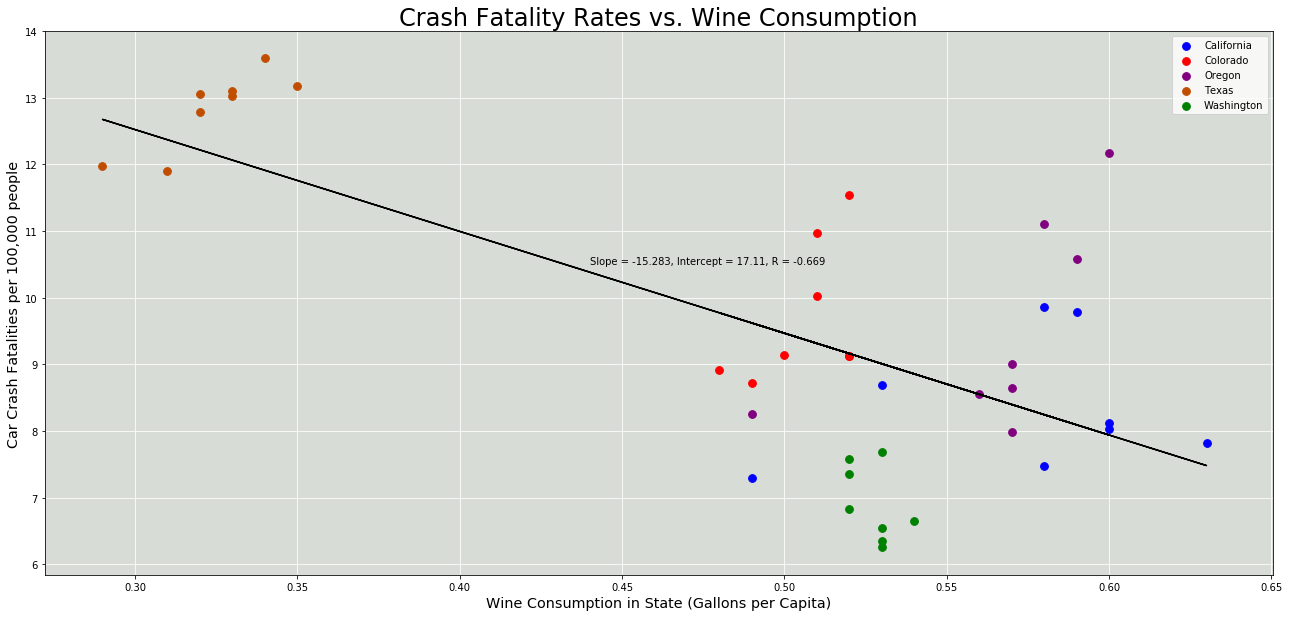

In [75]:
wc = wine_crash.loc[top_states, [x + "_cons" for x in crash_years[0:-1]]].values.flatten()
cr = wine_crash.loc[top_states, [x + "_crash" for x in crash_years[0:-1]]].values.flatten()*100000/\
wine_crash.loc[top_states, [x + "_pops" for x in crash_years[0:-1]]].values.flatten()
# There is actually a negative correlation between wine production and crash fatalities
cons_crash_regression = stats.linregress(wc,cr.astype(float))

plt.figure(figsize=(22,10), facecolor="None")
plt.title("Crash Fatality Rates vs. Wine Consumption", fontsize=24)
axes = plt.axes()

axes.set_facecolor("xkcd:light grey")
axes.set_axisbelow(True)
axes.grid(axis="both", color = "w")

axes.set_xlabel("Wine Consumption in State (Gallons per Capita)",size="x-large")
axes.set_ylabel("Car Crash Fatalities per 100,000 people",size="x-large")

for state in state_colors.keys():
    
    staterow = wine_crash["STATENAME"]==state
    
    # transposing these so that the scatter plot will accept them as arguments
    winecons = wine_crash.loc[staterow, [x + "_cons" for x in crash_years[0:-1]]].transpose()
    crashes = wine_crash.loc[staterow, [x + "_crash" for x in crash_years[0:-1]]].transpose()
    pops = wine_crash.loc[staterow, [x + "_pops" for x in crash_years[0:-1]]].transpose()
    # rate per 100,000
    crashrates = crashes.values*100000/pops.values
    
    plt.scatter(winecons.values, crashrates, c=state_colors[state], label=state, s=60)
    plt.legend(loc="upper right")

# here wc is the list of all wine consumption in the top 5 states, used previously for the regression
plt.plot(wc, wc*cons_crash_regression[0] + cons_crash_regression[1], c="black")
plt.annotate(f"Slope = {round(cons_crash_regression[0],4)}," + \
             f" Intercept = {round(cons_crash_regression[1],2)}, R = {round(cons_crash_regression[2],3)}", 
             (.44, 10.5))

plt.savefig(os.path.join("..","Images", "Crash Fatality Rates vs. Wine Consumption Among Top 5 States.png"), 
           bbox_inches="tight")

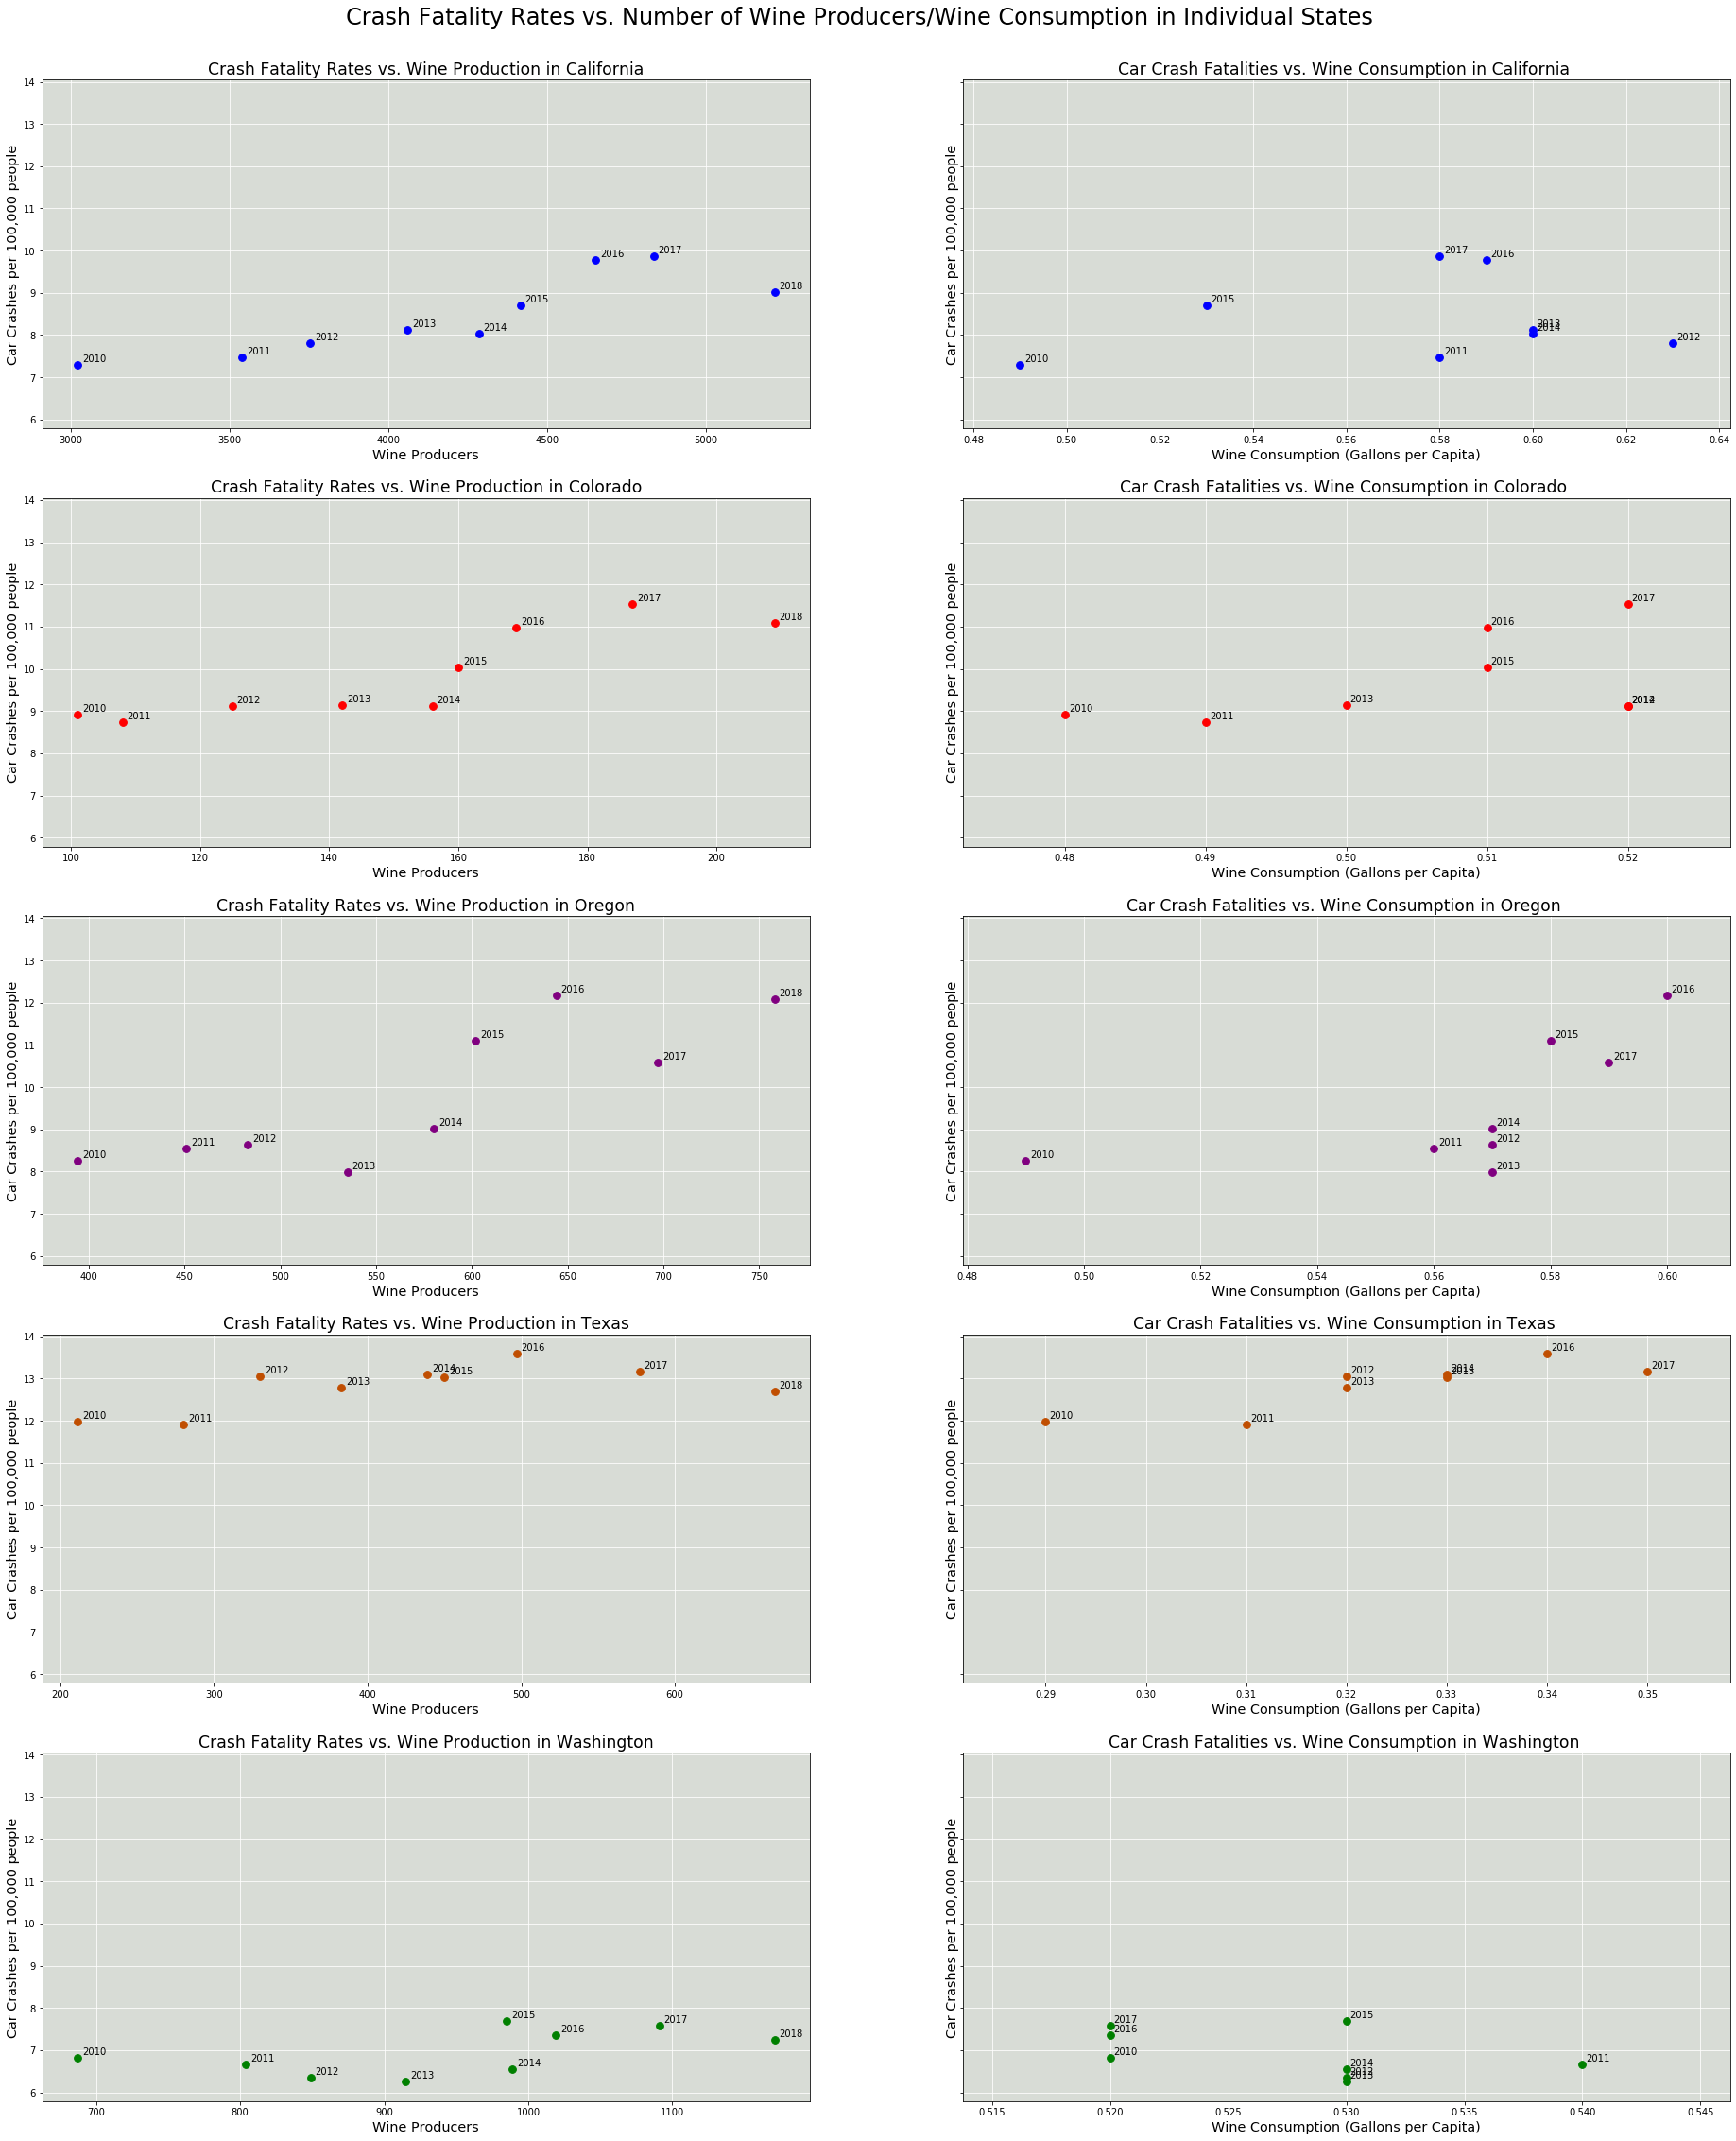

In [88]:
# 5 rows subplots for 5 states, production and consumption vs fatalitiy rate in respective columns
fig, axes = plt.subplots(5,2, sharey=True, figsize=(32,36), facecolor="None")

for i in range(axes.shape[0]):

    ax0 = axes[i,0]
    ax1 = axes[i,1]

    # state name and its boolean index
    state = list(state_colors.keys())[i]
    staterow = wine_crash["STATENAME"]==state

    # transposing these so that the scatter plot will accept them as arguments
    wineprods = wine_crash.loc[staterow, [x + "_wine" for x in crash_years]].transpose()
    winecons = wine_crash.loc[staterow, [x + "_cons" for x in crash_years[0:-1]]].transpose()
    crashes = wine_crash.loc[staterow, [x + "_crash" for x in crash_years]].transpose()
    pops = wine_crash.loc[staterow, [x + "_pops" for x in crash_years]].transpose()
    # rate per 100,000
    crashrates = crashes.values*100000/pops.values
    
    ax0.scatter(wineprods.values, crashrates, c=state_colors[state], label=state, s=60)

    ax0.set_facecolor("xkcd:light grey")
    ax0.set_axisbelow(True)
    ax0.grid(axis="both", color = "w")

    ax0.set_title(f"Crash Fatality Rates vs. Wine Production in {state}", size="xx-large")
    ax0.set_xlabel(f"Wine Producers", size="x-large")
    ax0.set_ylabel("Car Crashes per 100,000 people", size="x-large")
    
    ax1.scatter(winecons, crashes[0:-1].values*100000/pops[0:-1].values, c=state_colors[state], 
                label=state, s=60)

    ax1.set_facecolor("xkcd:light grey")
    ax1.set_axisbelow(True)
    ax1.grid(axis="both", color = "w")

    ax1.set_title(f"Car Crash Fatalities vs. Wine Consumption in {state} ", size="xx-large")
    ax1.set_xlabel(f"Wine Consumption (Gallons per Capita)", size="x-large")
    ax1.set_ylabel("Car Crashes per 100,000 people", size="x-large")
    
    for k in range(len(wineprods)):
        ax0.annotate(crash_years[k], (wineprods.values[k]+(max(wineprods.values)-min(wineprods.values))/150, 
                                      crashrates[k] + .08))
    for k in range(len(winecons)):
        ax1.annotate(crash_years[k], (winecons.values[k]+(max(winecons.values)-min(winecons.values))/150, 
                                      crashrates[k] + .08))

fig.suptitle("Crash Fatality Rates vs. Number of Wine Producers/Wine Consumption in Individual States",
            fontsize=24)
fig.subplots_adjust(top=.95)

plt.savefig(os.path.join("..","Images","Crash Fatality Rates vs. Number of Wine Producers And Wine Consumption in Individual States.png"),
           bbox_inches="tight")